# Train Semantic Segmentation

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pathmagic

import gc
import torch
import torch.cuda as cuda

from modules.model import JetSeg

from modules.mltools import (
    load_dataset, load_dataloaders, build_loss_fn, build_optimizer, training
)

from modules.utils import get_path, pkl, ModelConfigurator
from modules.vis import plot_config, plot_clear, plot_losses

from torchinfo import summary

In [3]:
# Cleaning
gc.collect()
cuda.empty_cache()

In [4]:
# Create configuration
dataset_name = "camvid"
jetseg_combination = 0
num_epochs = 10
batch_size = 4

# TODO: (check or improve jetseg combination)
# Number of Heads (now are 3)
# Last Feature Map Size (now is 8)

In [5]:
# Create Model Configuration
cfg = ModelConfigurator(comb=jetseg_combination, dataset_name=dataset_name,
                        last_fmap=8)


[INFO] JetSeg-C0 Configuration
{'stage0': [(7, 7)], 'stage1_residual': [(7, 1), (1, 7)], 'stage1_non_residual': [[(3, 3)], [(5, 1), (1, 5)], [(7, 7)]], 'stage2_residual': [(5, 5)], 'stage2_non_residual': [[(3, 3)], [(5, 1), (1, 5)]], 'stage3_residual': [(3, 3)], 'stage3_non_residual': [(1, 1)], 'decoder_head_stage1': 0, 'decoder_head_stage2': 0, 'decoder_head_stage3': 0}



In [6]:
# Build model
model = JetSeg(cfg)
model = model.to("cuda")

In [7]:
# Get torch summary
summary(model, input_size=(1, 3, cfg.img_sizes[0], cfg.img_sizes[1]))

/home/malopez/miniconda3/envs/nips2023/lib/python3.8/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/malopez/miniconda3/envs/nips2023/lib/python3.8/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                       Output Shape              Param #
JetSeg                                                       [1, 32, 960, 720]         --
├─JetNet: 1-1                                                [1, 384, 30, 23]          --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─JetBlock: 3-1                                    [1, 32, 480, 360]         307
│    │    └─JetBlock: 3-2                                    [1, 32, 480, 360]         2,370
│    │    └─JetBlock: 3-3                                    [1, 64, 240, 180]         6,082
│    │    └─JetBlock: 3-4                                    [1, 64, 240, 180]         3,618
│    │    └─JetBlock: 3-5                                    [1, 128, 120, 90]         8,418
│    │    └─JetBlock: 3-6                                    [1, 128, 120, 90]         5,120
│    │    └─JetBlock: 3-7                                    [1, 192, 60, 45]  

In [8]:
# Load data
datasets = load_dataset(dataset_name, cfg.num_classes)
dataloaders = load_dataloaders(datasets, batch_size)

In [9]:
# Getting test path
train_path = get_path("train")

# Building loss fn and optimizer
# loss_fn = build_loss_fn(loss_name="recall", pixels_per_class=cfg.pixels_per_class)
loss_fn = build_loss_fn(loss_name="bce")
optimizer = build_optimizer(optimizer_name="adamw", model=model)

# Setting up configuration paratemers
params = {}

# Create model name                                                         
model_name = "JetSeg-C" + str(jetseg_combination) + "-" + dataset_name.lower()     
                                                                            
params["debug"] = True
params["color_dict"] = datasets["train"].color_dict
params["model_name"] = model_name                                           
params["num_epochs"] = num_epochs                                           
params["early_stop"] = False                                                
params["dataloaders"] = dataloaders                                         
params["model"] = model.train()                                             
params["model_path"] = train_path                                           
params["device"] = "cuda"                                                   
params["loss_fn"] = loss_fn                                                 
params["optimizer"] = optimizer                                             
params["scheduler"] = None                                                  
params["num_classes"] = cfg.num_classes 

# Model training
train_out = training(params)

Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:55<00:00,  2.20s/it]


|Epoch 1 | Val loss 6.0386 | Val mIoU 100.0
|Epoch 1 | Train loss 6.005 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]


|Epoch 2 | Val loss 6.0126 | Val mIoU 100.0
|Epoch 2 | Train loss 6.0037 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]


|Epoch 3 | Val loss 6.0229 | Val mIoU 100.0
|Epoch 3 | Train loss 6.0046 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]


|Epoch 4 | Val loss 6.0222 | Val mIoU 100.0
|Epoch 4 | Train loss 6.0053 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.00s/it]


|Epoch 5 | Val loss 6.0205 | Val mIoU 100.0
|Epoch 5 | Train loss 6.0054 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.97s/it]


|Epoch 6 | Val loss 6.0135 | Val mIoU 100.0
|Epoch 6 | Train loss 6.004 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.01s/it]


|Epoch 7 | Val loss 6.0247 | Val mIoU 100.0
|Epoch 7 | Train loss 6.004 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.02s/it]


|Epoch 8 | Val loss 6.0087 | Val mIoU 100.0
|Epoch 8 | Train loss 6.0043 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  2.00s/it]


|Epoch 9 | Val loss 6.0212 | Val mIoU 100.0
|Epoch 9 | Train loss 6.0069 | Train mIoU 100.0



Val/Test: 100%|██████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]

|Epoch 10 | Val loss 6.0093 | Val mIoU 100.0
|Epoch 10 | Train loss 6.0044 | Train mIoU 100.0



In [12]:
# Save model weights
model_name = "JetSeg-C" + str(jetseg_combination) + "-" + dataset_name.lower()
ckp_model = train_path + model_name + ".pth"

# Create the model checkpoint
checkpoint = {
    'arch': "JetSeg",
    'epoch': len(train_out["train_losses"]),
    'valid_loss': train_out["val_losses"][-1],
    'model_state_dict': model.state_dict(),
    'loss_fn': loss_fn,
    'optimizer_state_dict': optimizer.state_dict(),
}

# Save model configuration
model_cfg = {"dataset_name": dataset_name.lower(),
             "jsc": jetseg_combination, "last_fmap": 8} 

# Save the model configuration
pkl_file = train_path + model_name + "-cfg.pkl"
pkl(pkl_file, model_cfg, mode=True)

# Saving checkpoint
torch.save(checkpoint, ckp_model)

# Saving losses
pkl_file = train_path + model_name + "-train-losses.pkl"
pkl(pkl_file, train_out, mode=True)

In [13]:
# Set cool plot configuration :3
plot_cfg = {
    "font.family": "sans-serif",
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "lines.markersize": 2,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
    'text.usetex': False,                                              
    "figure.figsize": [8, 8],
    "figure.dpi": 300,
}

plot_config(plot_cfg)

<Figure size 640x480 with 0 Axes>

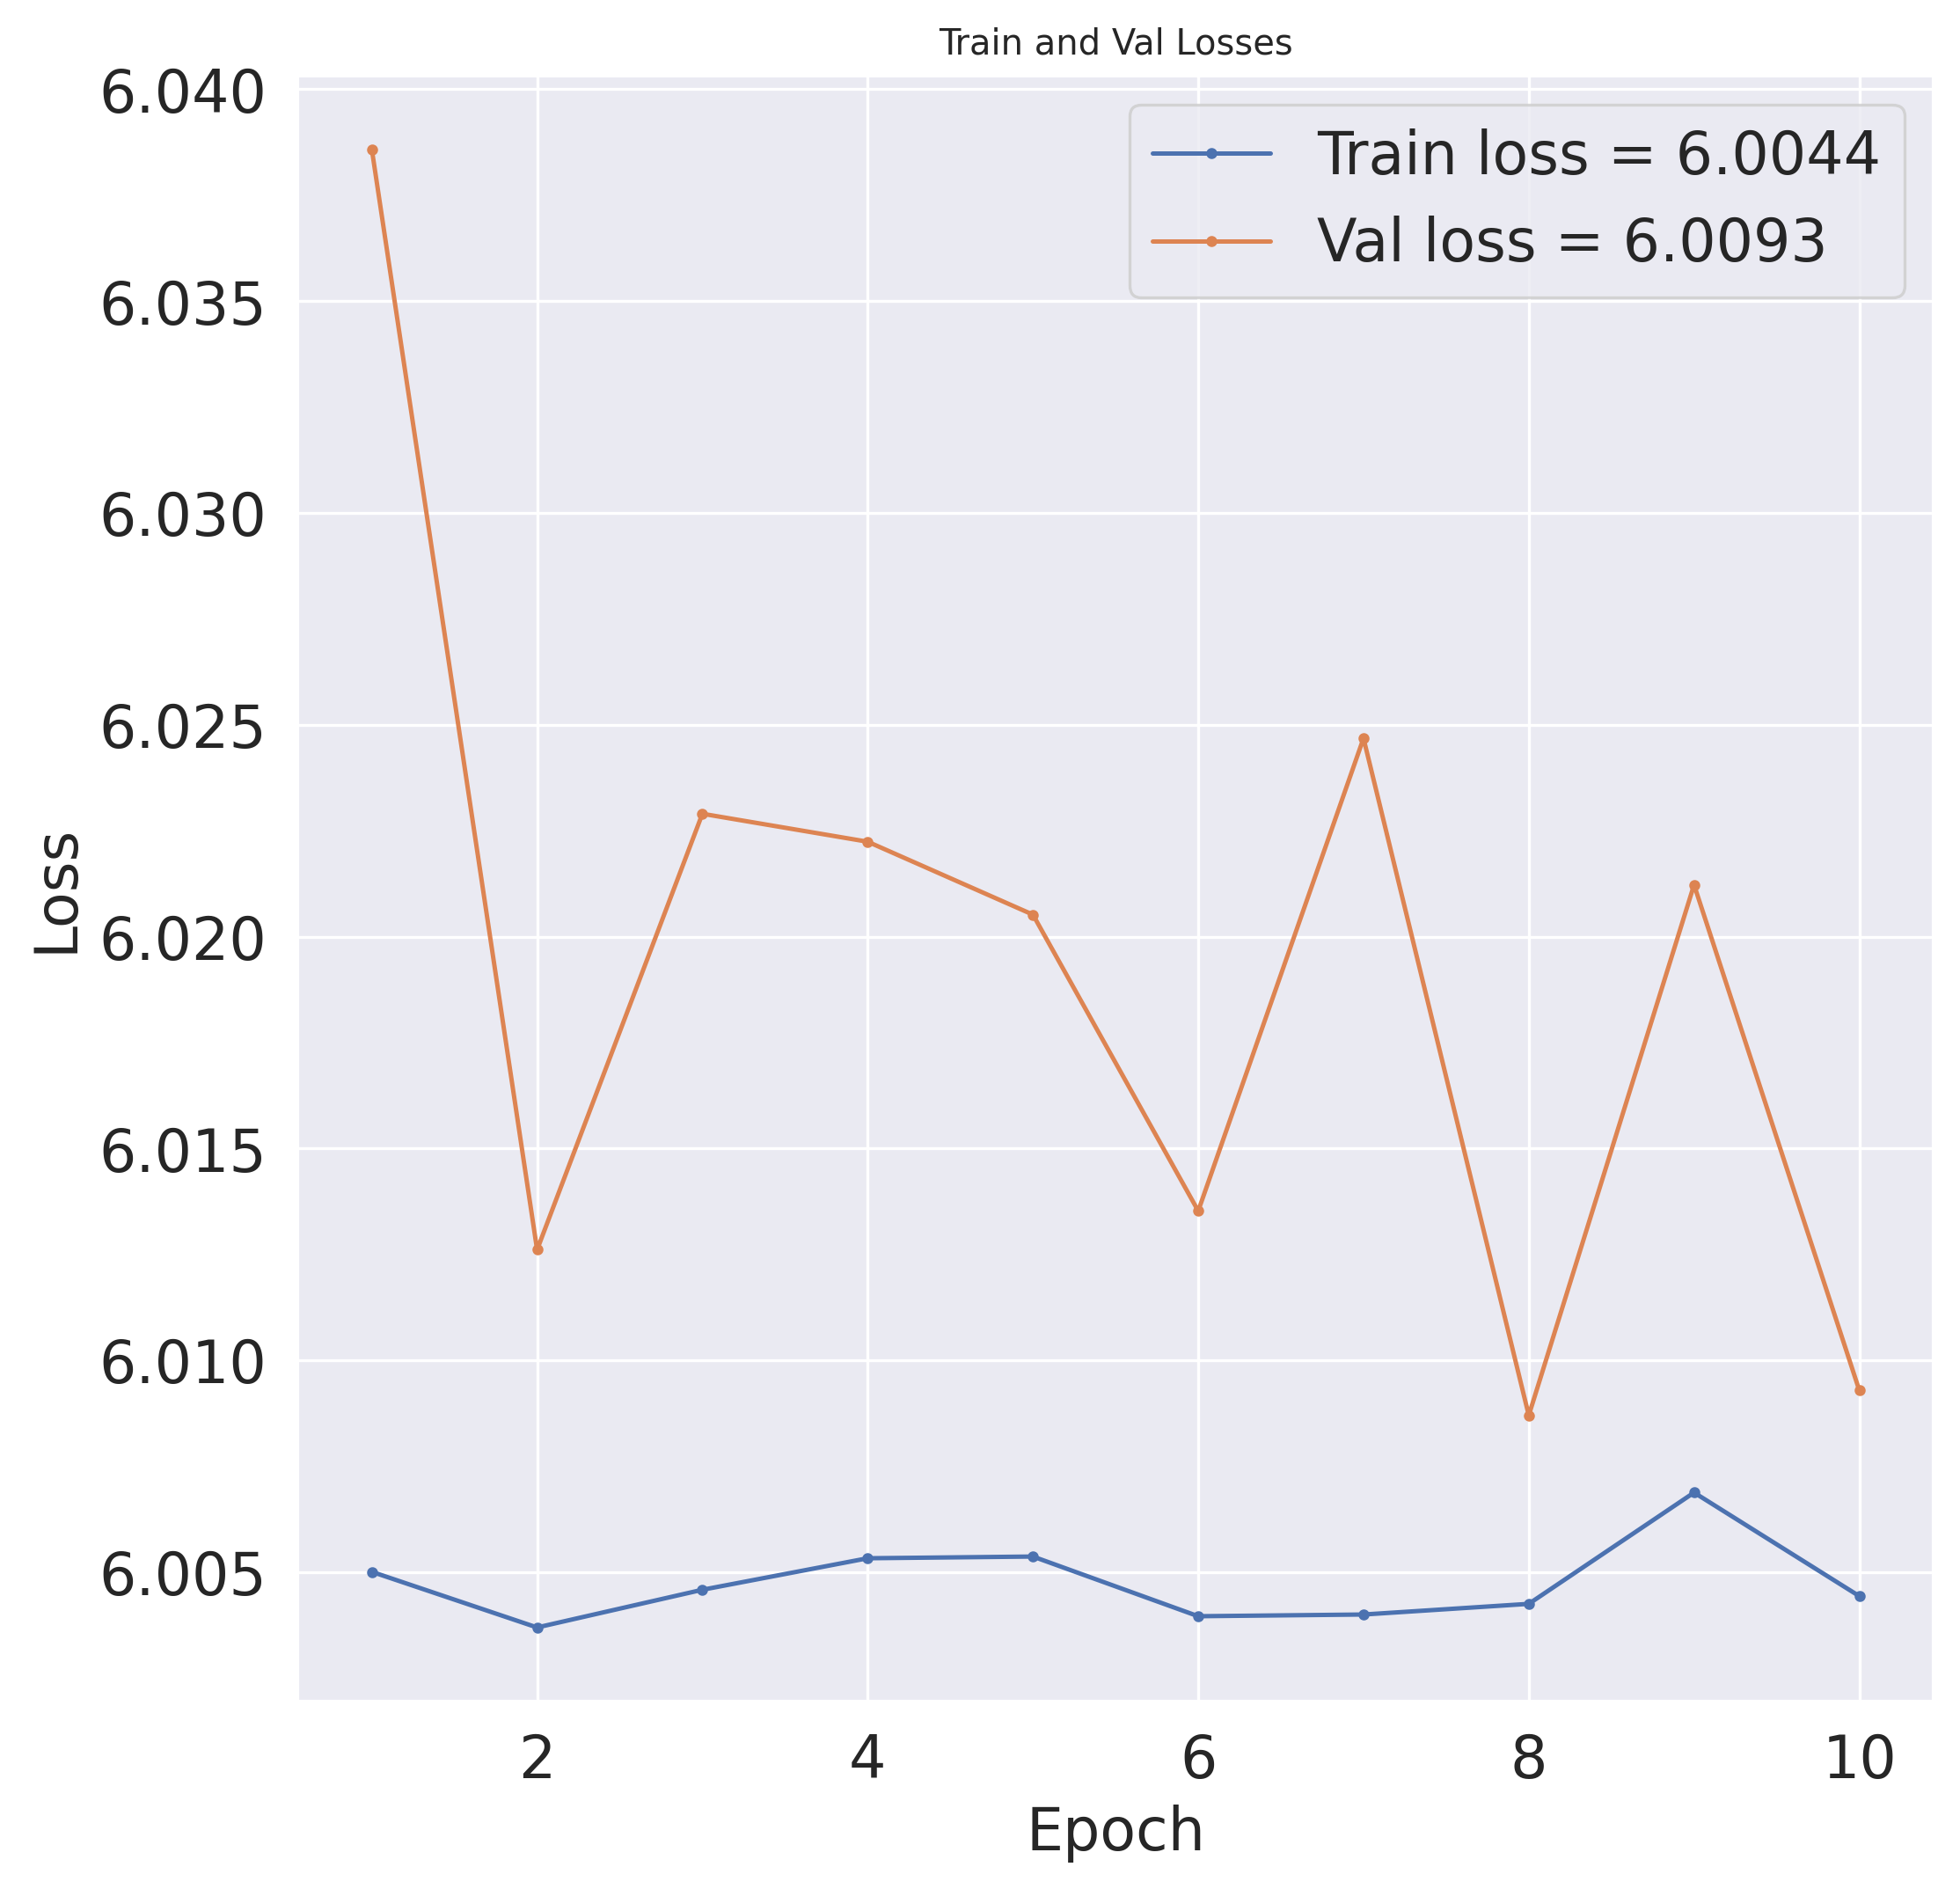

<Figure size 2400x2400 with 0 Axes>

In [14]:
# Plot losses
fig_name = train_path + model_name + "-train-eval-losses.png"
plot_losses(train_out, "loss", fig_name)
plot_clear()

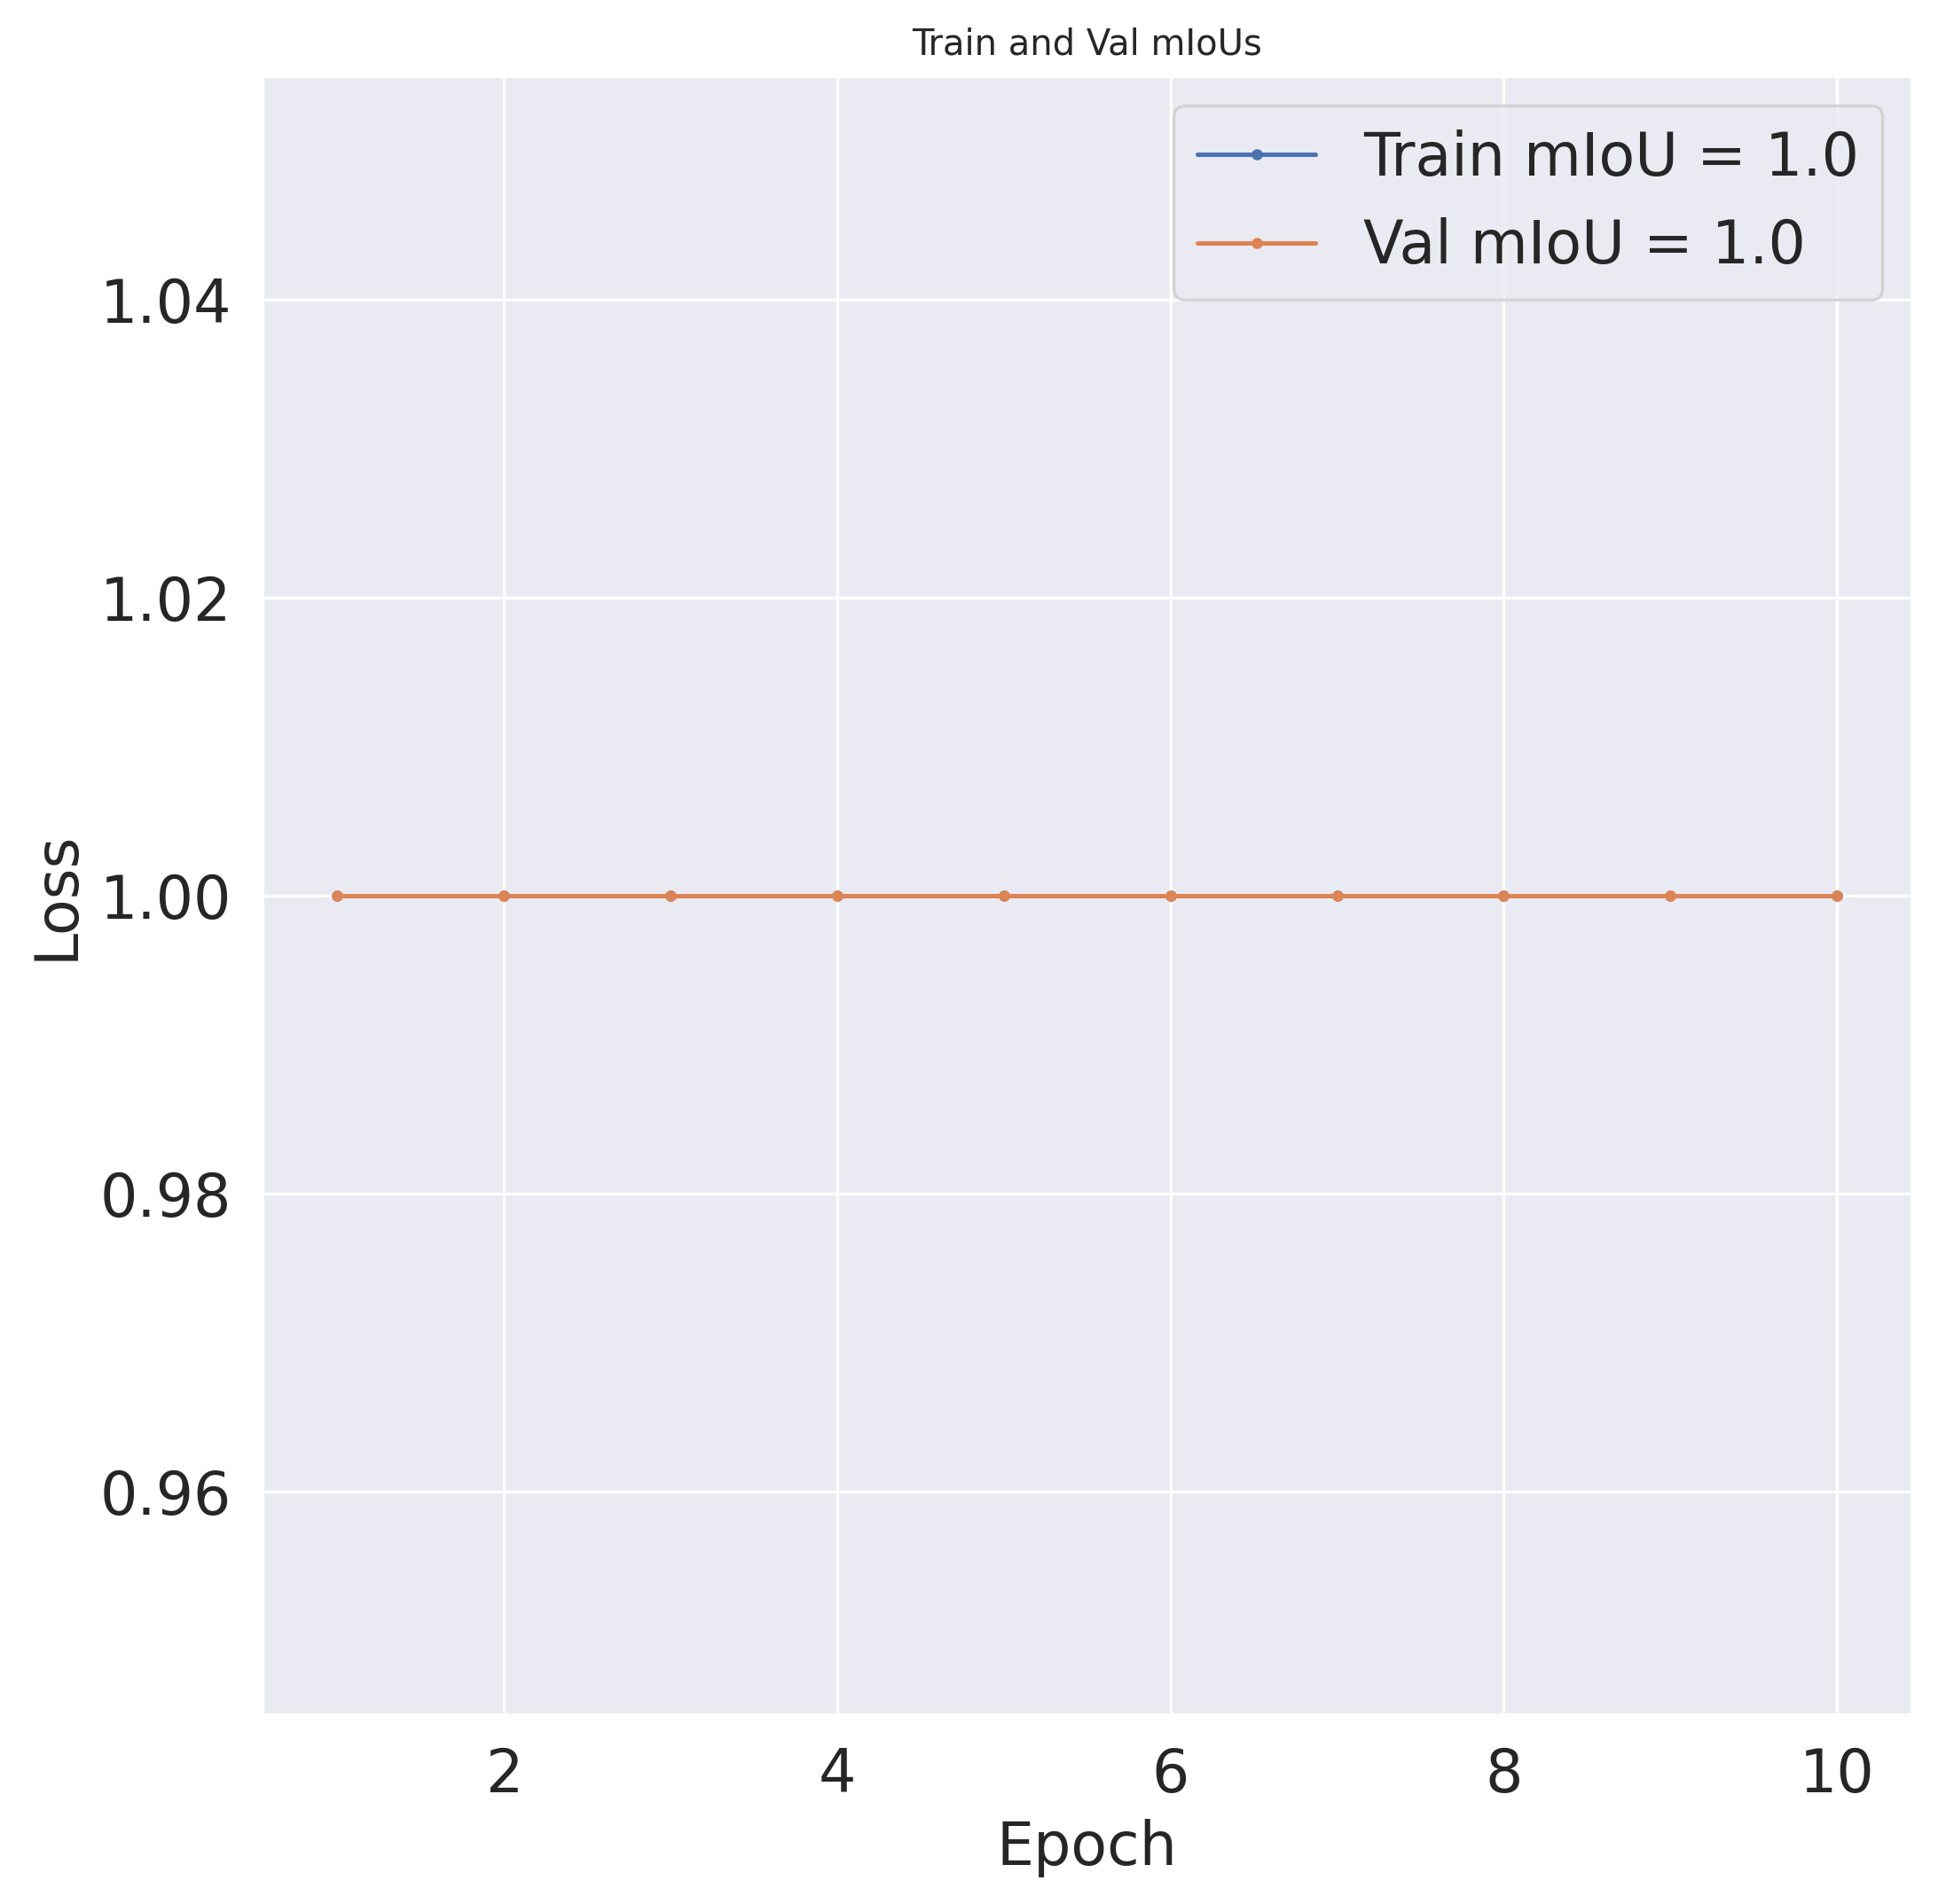

<Figure size 2400x2400 with 0 Axes>

In [15]:
# Plot losses
fig_name = train_path + model_name + "train-eval-mious.png"
plot_losses(train_out, "mious", fig_name)
plot_clear()